In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from itertools import chain
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.animation as animation
from IPython.display import HTML

## 6.3 ヒューリスティック探索
### 6.3.1 最良優先探索

In [2]:
# connect[i]はノード(i)と連結してるノード
connect = [[1, 5], [0, 2, 6], [1, 3, 7], [2, 4, 8], [3, 9],
        [6, 0, 10], [5, 7, 1, 11], [6, 8, 2, 12], [7, 9, 3, 13], [8, 4, 14],
        [11, 5, 15], [10, 12, 6, 16], [11, 13, 7, 17], [12, 14, 8, 18], [13, 9, 19],
        [16, 10, 20], [15, 17, 11, 21], [16, 18, 12, 22], [17, 19, 13, 23], [18, 14, 24],
        [21, 15], [20, 22, 16], [21, 23, 17], [22, 24, 18], [23, 19]]

width = 5
height = 5
goal = 23
hn = []

def manhattan_distance(i, height, width, goal):
    return np.abs(i//height - goal//height) + np.abs(i%width - goal%width)

# max(chain(*connect))はconnectの中の最大値を抜き出してるだけ.
for i in range(max(chain(*connect)) + 1):
    hn.append(manhattan_distance(i, height, width, goal))

In [28]:
for i in range(5):
    print(hn[i*5:i*5+5])

[7, 6, 5, 4, 5]
[6, 5, 4, 3, 4]
[5, 4, 3, 2, 3]
[4, 3, 2, 1, 2]
[3, 2, 1, 0, 1]


In [8]:
# prevは一個前にいた場所の値が格納される(後で使う)
prev = [-1]*(max(chain(*connect)) + 1)
open_list = [0]
close_list = []

while open_list:
    now = open_list.pop(0)
    close_list.append(now)
    a = [hn[i] for i in connect[now]]
    b = np.argsort(a)[0]
    c = connect[now][b]
    print(f'now: {now}, connect[now]: {connect[now]}\n \
a: {a}, b: {b}, c: {c}\n')
    prev[c] = now
    open_list.append(c)
    if c==goal:
        break


print(f'close_list:\n {close_list}')
print(f'prev:\n {prev}')

now: 0, connect[now]: [1, 5]
 a: [6, 6], b: 0, c: 1

now: 1, connect[now]: [0, 2, 6]
 a: [7, 5, 5], b: 1, c: 2

now: 2, connect[now]: [1, 3, 7]
 a: [6, 4, 4], b: 1, c: 3

now: 3, connect[now]: [2, 4, 8]
 a: [5, 5, 3], b: 2, c: 8

now: 8, connect[now]: [7, 9, 3, 13]
 a: [4, 4, 4, 2], b: 3, c: 13

now: 13, connect[now]: [12, 14, 8, 18]
 a: [3, 3, 3, 1], b: 3, c: 18

now: 18, connect[now]: [17, 19, 13, 23]
 a: [2, 2, 2, 0], b: 3, c: 23

close_list:
 [0, 1, 2, 3, 8, 13, 18]
prev:
 [-1, 0, 1, 2, -1, -1, -1, -1, 3, -1, -1, -1, -1, 8, -1, -1, -1, -1, 13, -1, -1, -1, -1, 18, -1]


In [10]:
p = goal
route = []
route.append(p)
while p:
    p = prev[p]
    route.append(p)
print(route)

[23, 18, 13, 8, 3, 2, 1, 0]


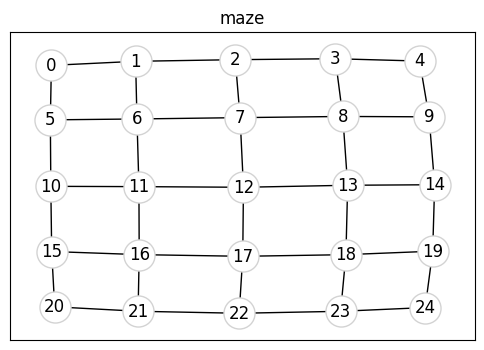

In [22]:
tree_graph = []
for i, tr in enumerate(connect):
    for j in tr:
        tree_graph.append((i, j))

G = nx.Graph()
G.add_nodes_from(range(max(chain(*connect))+1))
G.add_edges_from(tree_graph)
pos = nx.spring_layout(G, seed=22)
plt.figure(figsize=(6, 4))
plt.title('maze')
nx.draw_networkx(G, pos, node_color='w', edgecolors='lightgrey',
        node_size=500, with_labels=True)


In [26]:
def MakeField(maxnode, close_list, route):
    pc = ['w']*maxnode

    for i in close_list:#探索済み（クローズドリスト）の色
        pc[i]='lightgray'#白黒表示
        pc[i]='lightsalmon'#カラー表示
    if len(close_list)>0:#探索対象となるノードの色
        pc[close_list[-1]]='gray'#白黒表示
        pc[close_list[-1]]='lightgreen'#カラー表示
    for i in route:#ルートの表示用
        pc[i]='dimgray'#白黒表示
        pc[i]='cyan'#カラー表示
    return pc

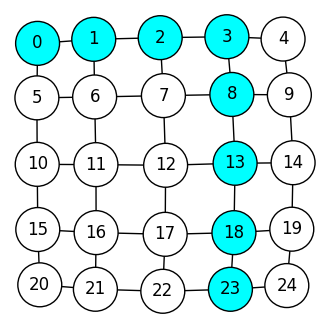

In [27]:
n = 0

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
def update(k):
    global n
    plt.cla()
    plt.axis('off')
    if n<len(close_list):
        pc = MakeField(len(list(G)), close_list[:n], [])
    else:
        pc = MakeField(len(list(G)), close_list, route[:n-len(close_list)])

    nx.draw_networkx(G, pos, node_color=pc, edgecolors='k', edge_color='k', node_size=1000, with_labels=True)
    n = n + 1

ani = animation.FuncAnimation(fig, update, interval = 100, frames = len(close_list)+len(route), repeat=False)
HTML(ani.to_jshtml())#jupyter notebookに表示
#ani.save("anim.gif")#gifアニメーションファイルの保存